In [154]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sn
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

In [3]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="ON/OFF code"></form>''')

# Análise Exploratória COVID-19

***

   O intuito deste Notebook é de explorar a base de dados públicos do novo coronavírus disponível no painel do [DataSUS](https://covid.saude.gov.br/). Informações sobre o que é o COVID-19 e outras dúvidas relacionadas podem ser encontradas na página [principal do repositório](https://github.com/leocneves/COVID-19) ou no próprio site do [Ministério da Saúde](https://coronavirus.saude.gov.br/sobre-a-doenca#o-que-e-covid).
Vamos visualizar algumas informações relevantes de maneira gráfica quanto ao registro de novos casos e óbitos por região e pelo Brasil, bem como informações de faixa etária e algumas outras comparações relevantes.

***

Conteúdo:

1. [Análise Inicial dos Dados](#1.-Análise-Inicial-dos-Dados)
    - Dados ausentes
    - Tipos de Dados
    
    
2. [Volumes dos Dados](#2.-Volumes-dos-Dados)
    - Visualizações de casos novos/óbitos por região/Brasil
    - Visualizações da evolução

***

### 1. Análise Inicial dos Dados

In [25]:
df = pd.read_csv('../datasets/arquivo_geral.csv', sep=';')

- Quantidade de valores ausentes e tipos das colunas:

In [106]:
pd.DataFrame(columns=['Coluna', 'Tipo', 'Qtd. Nulos'], data=np.array([df.columns.values, 
                                                             df.dtypes.values, 
                                                             df.isna().sum().values]).T)

,Coluna,Tipo,Qtd. Nulos
0,regiao,object,0
1,estado,object,0
2,data,datetime64[ns],0
3,casosNovos,int64,0
4,casosAcumulados,int64,0
5,obitosNovos,int64,0
6,obitosAcumulados,int64,0


In [27]:
# Transformações Necessárias
df['data'] = pd.to_datetime(df['data'], format='%Y-%m-%d') # Transformação da coluna de data de tipo string -> tipod data

### 2. Volumes dos Dados

- Acumulado de casos por região, óbitos e letalidade

,regiao,Total de Casos,Total de Obitos,% Região para Brasil,% Obitos
0,Centro-Oeste,4278,111,2.94,2.59
1,Nordeste,45724,2774,31.46,6.07
2,Norte,23207,1557,15.97,6.71
3,Sudeste,64756,5195,44.56,8.02
4,Sul,7363,260,5.07,3.53


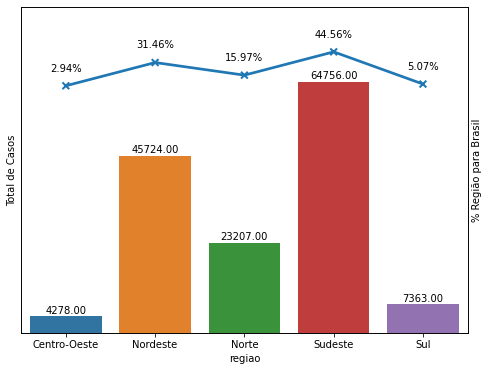

In [132]:
df_vol = pd.pivot_table(df, values=['casosNovos', 'obitosNovos'], 
               columns=['regiao'], aggfunc=[np.sum]).xs('sum', axis=1, drop_level=True).T.reset_index()

df_vol.rename(columns={'casosNovos':'Total de Casos', 'obitosNovos':'Total de Obitos'}, inplace = True)

df_vol['% Região para Brasil'] = round((df_vol['Total de Casos'] / df_vol['Total de Casos'].sum()) * 100, 2) # % da região 
df_vol['% Obitos'] = round((df_vol['Total de Obitos'] / df_vol['Total de Casos']) * 100, 2) # Letalidade
display(df_vol)

fig, ax = plt.subplots(figsize=(8,6)) 
# Criando os plots
sn.barplot(x='regiao', y='Total de Casos', data=df_vol, ax=ax)
ax2 = plt.twinx()
sn.pointplot(x='regiao', y='% Região para Brasil', data=df_vol, ax=ax2, markers='x')

# Setando configurações
ax.set(ylim=(0, df_vol['Total de Casos'].max()*1.3), yticks=[])
ax2.set(ylim=(-300, 100), yticks=[])

# Anotando
for rect, i in zip(ax.patches, df_vol['% Região para Brasil'].values):
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    # Number of points between bar and label. Change to your liking.
    space = 1
    # Vertical alignment for positive values
    va = 'bottom'

    # If value of bar is negative: Place label below bar
    if y_value < 0:
        # Invert space to place label below
        space *= -1
        # Vertically align label at top
        va = 'top'

    # Use Y value as label and format number with one decimal place
    label = "{:.2f}".format(y_value)

    # Create annotation
    ax.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(0, space),          # Vertically shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        ha='center',                # Horizontally center label
        va=va)                      # Vertically align label differently for
                                    # positive and negative values.
        
    ax2.annotate(
        str(i) + '%\n',                      # Use `label` as label
        (x_value, i),         # Place label at end of the bar
        xytext=(0, space),          # Vertically shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        ha='center',                # Horizontally center label
        va=va)                      # Vertically align label differently for
                                    # positive and negative values.

plt.show()

- Acumulado semanal Brasil

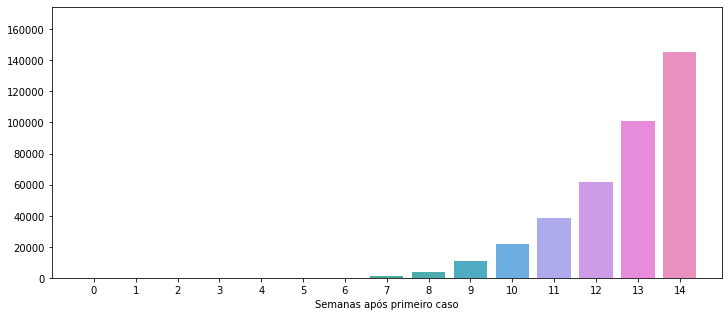

In [184]:
df_group_data = df.groupby(pd.Grouper(key='data', freq='W')).sum().reset_index()

df_group_data['casosNovosAcumulado'] = df_group_data['casosNovos'].cumsum()

fig, ax = plt.subplots(figsize=(12,5))
g = sn.barplot(x='data', y='casosNovosAcumulado', data=df_group_data) # , hue='regiao', ax=ax

ax.set(xticklabels=list(range(len(df_group_data['data']))),
     xlabel='Semanas após primeiro caso', ylabel='')

# # calculate linear regression function
# X = list(range(len(df_group_data['data'])))

# slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x=np.array(X), y=df_group_data['casosNovosAcumulado'].apply(np.log1p))

# # X.extend([15,16])

# g.plot(X, np.exp(intercept + slope * np.array(X)), 'r')

g.set(xlim=(-1, 15), ylim=(0, df_group_data['casosNovosAcumulado'].max()*1.2))
plt.show()

- Acumulado semanal Brasil por região

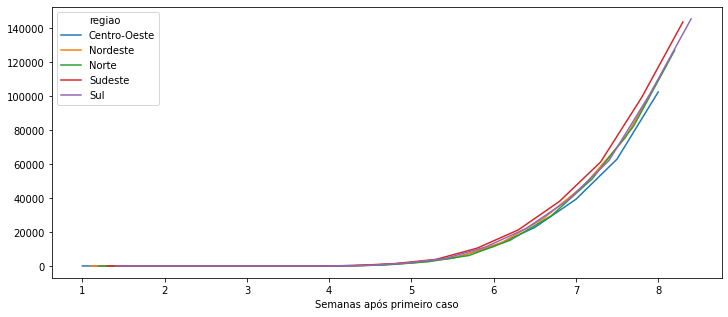

In [191]:
df_group_data = df.groupby([pd.Grouper(key='data', freq='W'), 'regiao']).sum().reset_index()

df_group_data['casosNovosAcumulado'] = df_group_data['casosNovos'].cumsum()

fig, ax = plt.subplots(figsize=(12,5))
g = sn.lineplot(x=list(range(len(df_group_data['data']))), y='casosNovosAcumulado', data=df_group_data, hue='regiao', ax=ax) 
g.set(xticklabels=list(range(len(df_group_data['data']))),
     xlabel='Semanas após primeiro caso', ylabel='')

# g.set(xlim=(-1, 15))
plt.show()